In [52]:
#Importing Libraries
import numpy as np 
import pandas as pd 
import torch
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
from IPython.core.display import display
from PIL import Image as PILImage
import music21
from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import os
import sys

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(420)

In [53]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import torch
import torch.nn as nn
import torch.optim as optim

In [55]:
us = environment.UserSettings()
#us.create()

In [56]:
us.keys()

['directoryScratch',
 'lilypondPath',
 'lilypondVersion',
 'lilypondFormat',
 'lilypondBackend',
 'musicxmlPath',
 'midiPath',
 'graphicsPath',
 'vectorPath',
 'pdfPath',
 'braillePath',
 'musescoreDirectPNGPath',
 'showFormat',
 'writeFormat',
 'ipythonShowFormat',
 'autoDownload',
 'debug',
 'warnings',
 'localCorpusSettings',
 'localCorporaSettings',
 'manualCoreCorpusPath',
 'localCorpusPath']

In [57]:
us['lilypondPath'] = '/opt/homebrew/bin/lilypond'
us['lilypondVersion'] = '2.24.3'
us['lilypondBackend'] = '/opt/homebrew/Cellar/lilypond'
us['graphicsPath'] = '/Users/mattiacarolo/Coding/TesiArchive/generation'
#us['musescoreDrectPNGPath'] = '/Applications/MuseScore3.app'
print (us['lilypondPath'])

/opt/homebrew/bin/lilypond


In [89]:
filepath = "./Dataset/DATASETGROSSO/ATTENTOADAPRIRE/Unhinged/"
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

In [90]:
class MusicDataset(Dataset):
    def __init__(self, corpus, mapping, length=60):
        self.length = length
        self.mapping = mapping
        self.corpus = corpus
        self.features, self.targets = self.preprocess_data(corpus)
        self.L_symb = len(set(mapping.values()))

    def preprocess_data(self, corpus):
        features = []
        targets = []
        L_corpus = len(corpus)
        for i in range(0, L_corpus - self.length, 1):
            feature = corpus[i:i + self.length]
            target = corpus[i + self.length]
            features.append([self.mapping[j] for j in feature])
            targets.append(self.mapping[target])
        return np.array(features), np.array(targets)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        feature = self.features[idx]
        target = self.targets[idx]
        feature = np.reshape(feature, (self.length, 1)) / float(self.L_symb)
        target = to_categorical(target, num_classes=self.L_symb)
        return torch.tensor(feature, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

In [91]:
#Helping function        
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))

Total notes in all the Chopin midis in the dataset: 26440


In [92]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 26440
Number of unique characters: 521


In [93]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['B-2', 'B-3', 'B-2', 'B-2', 'B-3', 'B-2', 'B-2', 'B-3', 'B-2', 'B-2', 'B-3', 'B-1', 'B-3', 'B-2', 'B-3', 'B-3', 'B-2', 'B-2', 'B-3', 'B-2', 'B-2', 'B-3', 'D3', 'E4', 'A3', 'D3', 'D4', 'A3', 'D3', 'E4', 'D3', 'D3', 'D4', 'E-3', 'E-4', 'E-3', 'E-4', '7.0', 'D4', 'C3', 'C4', 'F2', 'B-3', 'F2', 'A3', 'F2', 'C3', 'G3', 'C3', 'F2']


In [94]:
#First Lets write some functions that we need to look into the data
def show(music):
    display(Image(str(music.write("musicxml.png"))))
    
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
#show(Melody_Snippet)

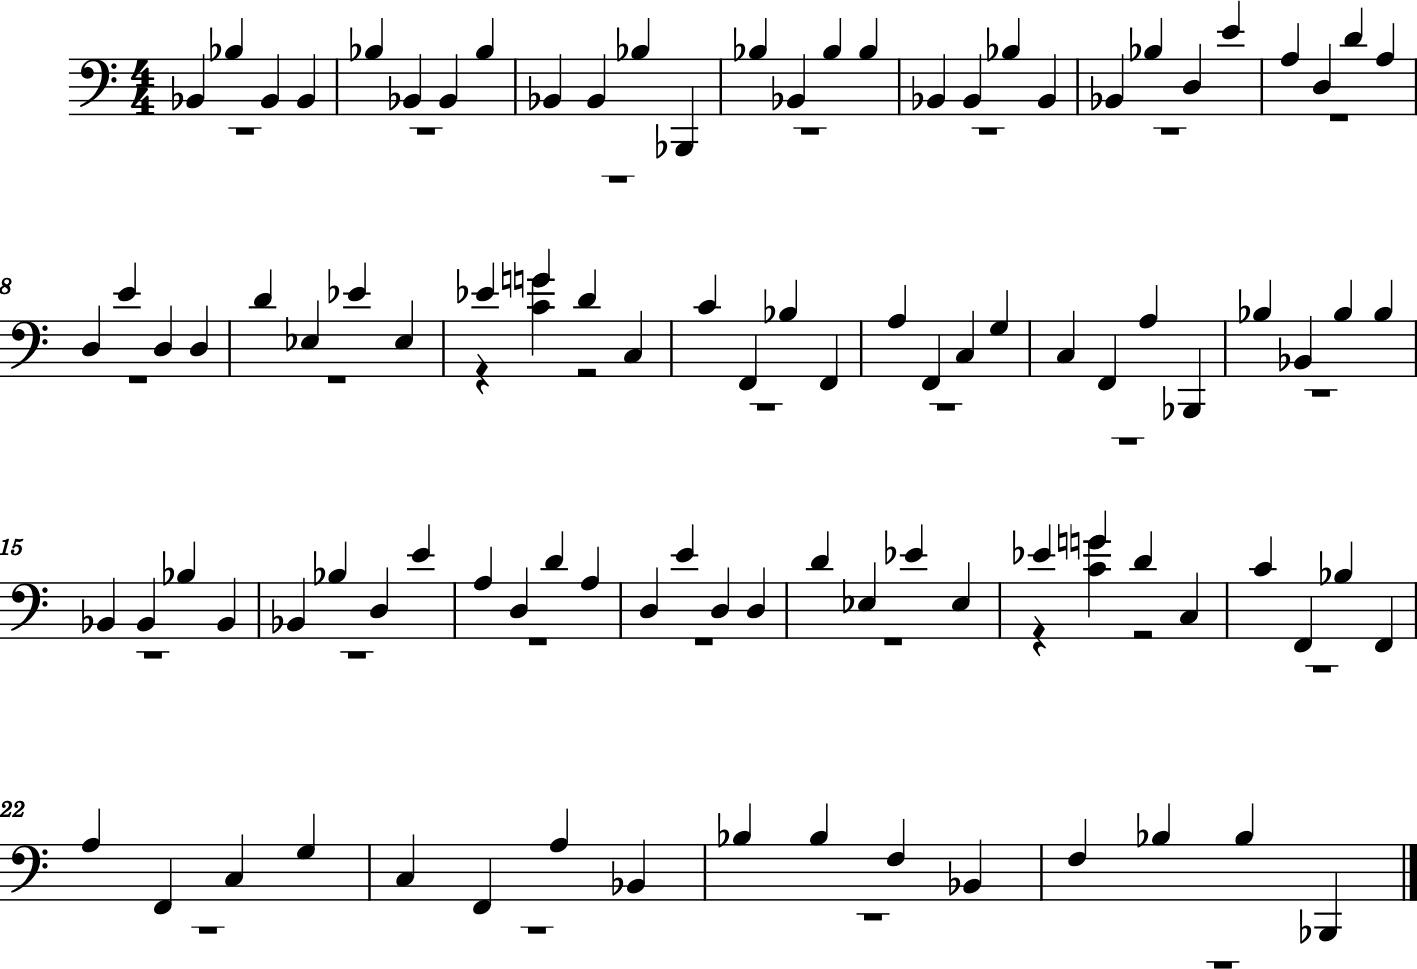

In [95]:
# Step 1: Write the music to a PNG file
image_path = Melody_Snippet.write("musicxml.png")

# Step 2: Open the PNG file with Pillow
original = PILImage.open(image_path)

# Step 3: Create a new image with a white background
white_background = PILImage.new("RGB", original.size, (255, 255, 255))

# Step 4: Paste the original image onto the white background
white_background.paste(original, (0, 0), original)

# Step 5: Save the new image
new_image_path = "musicxml_white_bg.png"
white_background.save(new_image_path)

# Display the new image in the Jupyter notebook
display(Image(new_image_path))


In [96]:
#Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 521


In [97]:

#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 50.74856046065259
Most frequent note in Corpus appeared: 681 times
Least frequent note in Corpus appeared: 1 time


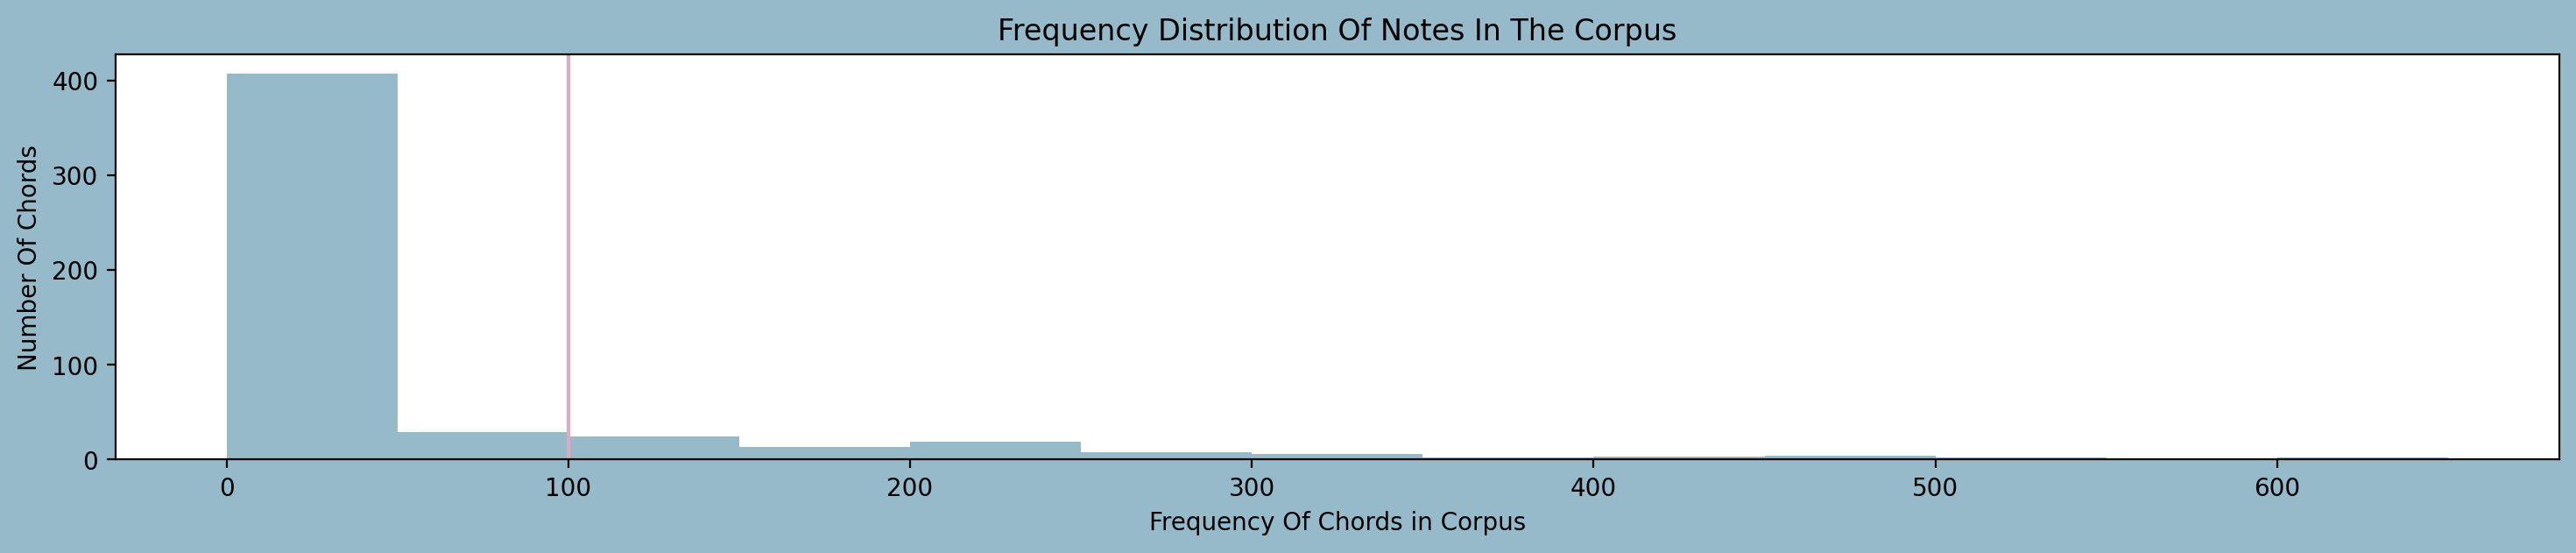

In [98]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

In [99]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 436


In [100]:
#Eleminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 22314


In [101]:
corpus = Corpus
mapping = mapping

dataset = MusicDataset(corpus, mapping)

# Create train and validation splits
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders for train and validation sets
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [102]:
class MusicLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(MusicLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim1, batch_first=True, dropout=0.1)
        self.lstm2 = nn.LSTM(hidden_dim1, hidden_dim2, batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.dense1 = nn.Linear(hidden_dim2, 256)
        self.dense2 = nn.Linear(256, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]  # Take the last time step output
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.softmax(x)
        return x

In [103]:
# Assuming X_train has shape (num_samples, length, 1)
input_dim = 1  # Number of input features (same as X_train.shape[2])
hidden_dim1 = 512
hidden_dim2 = 256
output_dim = len(mapping)  # Number of output classes (same as y_train.shape[1])

model = MusicLSTM(input_dim, hidden_dim1, hidden_dim2, output_dim)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()


#optimizer = optim.Adamax(model.parameters(), lr=0.01)
optimizer = optim.RMSprop(model.parameters(), lr=0.01)

In [104]:
num_epochs = 100  # Define the number of epochs

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    # Create a progress bar for batches
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for inputs, targets in train_loader:
            optimizer.zero_grad()  # Clear the gradients

            # Forward pass
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, torch.argmax(targets, dim=1))

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Update the progress bar
            pbar.set_postfix(loss=running_loss / (pbar.n + 1))
            pbar.update(1)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch 1/100: 100%|██████████| 279/279 [01:00<00:00,  4.61batch/s, loss=6.24]


Epoch [1/100], Loss: 6.2430


Epoch 2/100: 100%|██████████| 279/279 [01:01<00:00,  4.54batch/s, loss=6.24]


Epoch [2/100], Loss: 6.2422


Epoch 3/100: 100%|██████████| 279/279 [01:02<00:00,  4.44batch/s, loss=6.24]


Epoch [3/100], Loss: 6.2425


Epoch 4/100: 100%|██████████| 279/279 [01:04<00:00,  4.31batch/s, loss=6.24]


Epoch [4/100], Loss: 6.2425


Epoch 5/100: 100%|██████████| 279/279 [00:58<00:00,  4.79batch/s, loss=6.24]


Epoch [5/100], Loss: 6.2422


Epoch 6/100: 100%|██████████| 279/279 [00:55<00:00,  5.00batch/s, loss=6.24]


Epoch [6/100], Loss: 6.2425


Epoch 7/100: 100%|██████████| 279/279 [00:58<00:00,  4.80batch/s, loss=6.24]


Epoch [7/100], Loss: 6.2422


Epoch 8/100: 100%|██████████| 279/279 [01:04<00:00,  4.32batch/s, loss=6.24]


Epoch [8/100], Loss: 6.2425


Epoch 9/100: 100%|██████████| 279/279 [00:57<00:00,  4.87batch/s, loss=6.24]


Epoch [9/100], Loss: 6.2425


Epoch 10/100: 100%|██████████| 279/279 [00:56<00:00,  4.98batch/s, loss=6.24]


Epoch [10/100], Loss: 6.2425


Epoch 11/100: 100%|██████████| 279/279 [00:56<00:00,  4.93batch/s, loss=6.24]


Epoch [11/100], Loss: 6.2425


Epoch 12/100: 100%|██████████| 279/279 [00:55<00:00,  4.99batch/s, loss=6.24]


Epoch [12/100], Loss: 6.2425


Epoch 13/100: 100%|██████████| 279/279 [00:56<00:00,  4.96batch/s, loss=6.24]


Epoch [13/100], Loss: 6.2425


Epoch 14/100: 100%|██████████| 279/279 [00:55<00:00,  4.98batch/s, loss=6.24]


Epoch [14/100], Loss: 6.2425


Epoch 15/100: 100%|██████████| 279/279 [00:56<00:00,  4.93batch/s, loss=6.24]


Epoch [15/100], Loss: 6.2425


Epoch 16/100: 100%|██████████| 279/279 [00:55<00:00,  5.01batch/s, loss=6.24]


Epoch [16/100], Loss: 6.2425


Epoch 17/100: 100%|██████████| 279/279 [00:56<00:00,  4.98batch/s, loss=6.24]


Epoch [17/100], Loss: 6.2425


Epoch 18/100: 100%|██████████| 279/279 [00:55<00:00,  5.00batch/s, loss=6.24]


Epoch [18/100], Loss: 6.2425


Epoch 19/100: 100%|██████████| 279/279 [00:56<00:00,  4.98batch/s, loss=6.24]


Epoch [19/100], Loss: 6.2425


Epoch 20/100: 100%|██████████| 279/279 [00:56<00:00,  4.98batch/s, loss=6.24]


Epoch [20/100], Loss: 6.2425


Epoch 21/100: 100%|██████████| 279/279 [00:56<00:00,  4.97batch/s, loss=6.24]


Epoch [21/100], Loss: 6.2425


Epoch 22/100: 100%|██████████| 279/279 [00:56<00:00,  4.95batch/s, loss=6.24]


Epoch [22/100], Loss: 6.2425


Epoch 23/100: 100%|██████████| 279/279 [00:55<00:00,  5.00batch/s, loss=6.24]


Epoch [23/100], Loss: 6.2425


Epoch 24/100: 100%|██████████| 279/279 [00:55<00:00,  5.00batch/s, loss=6.24]


Epoch [24/100], Loss: 6.2425


Epoch 25/100: 100%|██████████| 279/279 [00:55<00:00,  5.01batch/s, loss=6.24]


Epoch [25/100], Loss: 6.2425


Epoch 26/100: 100%|██████████| 279/279 [00:56<00:00,  4.98batch/s, loss=6.24]


Epoch [26/100], Loss: 6.2422


Epoch 27/100: 100%|██████████| 279/279 [00:55<00:00,  4.99batch/s, loss=6.24]


Epoch [27/100], Loss: 6.2425


Epoch 28/100: 100%|██████████| 279/279 [00:56<00:00,  4.98batch/s, loss=6.24]


Epoch [28/100], Loss: 6.2422


Epoch 29/100: 100%|██████████| 279/279 [00:56<00:00,  4.96batch/s, loss=6.24]


Epoch [29/100], Loss: 6.2425


Epoch 30/100: 100%|██████████| 279/279 [00:56<00:00,  4.98batch/s, loss=6.24]


Epoch [30/100], Loss: 6.2422


Epoch 31/100: 100%|██████████| 279/279 [00:56<00:00,  4.96batch/s, loss=6.24]


Epoch [31/100], Loss: 6.2425


Epoch 32/100: 100%|██████████| 279/279 [00:55<00:00,  4.99batch/s, loss=6.24]


Epoch [32/100], Loss: 6.2425


Epoch 33/100: 100%|██████████| 279/279 [00:55<00:00,  5.00batch/s, loss=6.24]


Epoch [33/100], Loss: 6.2425


Epoch 34/100: 100%|██████████| 279/279 [00:55<00:00,  5.03batch/s, loss=6.24]


Epoch [34/100], Loss: 6.2425


Epoch 35/100: 100%|██████████| 279/279 [00:56<00:00,  4.98batch/s, loss=6.24]


Epoch [35/100], Loss: 6.2425


Epoch 36/100: 100%|██████████| 279/279 [00:56<00:00,  4.98batch/s, loss=6.24]


Epoch [36/100], Loss: 6.2425


Epoch 37/100: 100%|██████████| 279/279 [00:56<00:00,  4.98batch/s, loss=6.24]


Epoch [37/100], Loss: 6.2425


Epoch 38/100: 100%|██████████| 279/279 [00:55<00:00,  5.00batch/s, loss=6.24]


Epoch [38/100], Loss: 6.2422


Epoch 39/100: 100%|██████████| 279/279 [00:56<00:00,  4.97batch/s, loss=6.24]


Epoch [39/100], Loss: 6.2425


Epoch 40/100: 100%|██████████| 279/279 [00:55<00:00,  5.00batch/s, loss=6.24]


Epoch [40/100], Loss: 6.2422


Epoch 41/100: 100%|██████████| 279/279 [00:55<00:00,  4.99batch/s, loss=6.24]


Epoch [41/100], Loss: 6.2422


Epoch 42/100: 100%|██████████| 279/279 [00:55<00:00,  5.00batch/s, loss=6.24]


Epoch [42/100], Loss: 6.2425


Epoch 43/100: 100%|██████████| 279/279 [00:55<00:00,  5.01batch/s, loss=6.24]


Epoch [43/100], Loss: 6.2422


Epoch 44/100: 100%|██████████| 279/279 [00:55<00:00,  4.99batch/s, loss=6.24]


Epoch [44/100], Loss: 6.2422


Epoch 45/100: 100%|██████████| 279/279 [00:55<00:00,  4.98batch/s, loss=6.24]


Epoch [45/100], Loss: 6.2422


Epoch 46/100: 100%|██████████| 279/279 [00:56<00:00,  4.93batch/s, loss=6.24]


Epoch [46/100], Loss: 6.2425


Epoch 47/100: 100%|██████████| 279/279 [00:56<00:00,  4.95batch/s, loss=6.24]


Epoch [47/100], Loss: 6.2425


Epoch 48/100: 100%|██████████| 279/279 [00:56<00:00,  4.97batch/s, loss=6.24]


Epoch [48/100], Loss: 6.2425


Epoch 49/100: 100%|██████████| 279/279 [00:56<00:00,  4.98batch/s, loss=6.24]


Epoch [49/100], Loss: 6.2425


Epoch 50/100: 100%|██████████| 279/279 [00:55<00:00,  4.98batch/s, loss=6.24]


Epoch [50/100], Loss: 6.2422


Epoch 51/100: 100%|██████████| 279/279 [00:55<00:00,  5.01batch/s, loss=6.24]


Epoch [51/100], Loss: 6.2425


Epoch 52/100: 100%|██████████| 279/279 [00:56<00:00,  4.95batch/s, loss=6.24]


Epoch [52/100], Loss: 6.2425


Epoch 53/100: 100%|██████████| 279/279 [00:56<00:00,  4.97batch/s, loss=6.24]


Epoch [53/100], Loss: 6.2419


Epoch 54/100: 100%|██████████| 279/279 [00:56<00:00,  4.95batch/s, loss=6.24]


Epoch [54/100], Loss: 6.2425


Epoch 55/100: 100%|██████████| 279/279 [00:55<00:00,  4.98batch/s, loss=6.24]


Epoch [55/100], Loss: 6.2425


Epoch 56/100: 100%|██████████| 279/279 [00:55<00:00,  5.01batch/s, loss=6.24]


Epoch [56/100], Loss: 6.2425


Epoch 57/100: 100%|██████████| 279/279 [00:55<00:00,  5.00batch/s, loss=6.24]


Epoch [57/100], Loss: 6.2425


Epoch 58/100: 100%|██████████| 279/279 [00:55<00:00,  4.99batch/s, loss=6.24]


Epoch [58/100], Loss: 6.2425


Epoch 59/100: 100%|██████████| 279/279 [00:55<00:00,  5.00batch/s, loss=6.24]


Epoch [59/100], Loss: 6.2422


Epoch 60/100: 100%|██████████| 279/279 [00:56<00:00,  4.97batch/s, loss=6.24]


Epoch [60/100], Loss: 6.2425


Epoch 61/100: 100%|██████████| 279/279 [00:55<00:00,  5.01batch/s, loss=6.24]


Epoch [61/100], Loss: 6.2422


Epoch 62/100: 100%|██████████| 279/279 [00:55<00:00,  4.99batch/s, loss=6.24]


Epoch [62/100], Loss: 6.2425


Epoch 63/100: 100%|██████████| 279/279 [00:56<00:00,  4.97batch/s, loss=6.24]


Epoch [63/100], Loss: 6.2425


Epoch 64/100: 100%|██████████| 279/279 [00:56<00:00,  4.97batch/s, loss=6.24]


Epoch [64/100], Loss: 6.2425


Epoch 65/100: 100%|██████████| 279/279 [00:56<00:00,  4.96batch/s, loss=6.24]


Epoch [65/100], Loss: 6.2425


Epoch 66/100: 100%|██████████| 279/279 [00:55<00:00,  5.00batch/s, loss=6.24]


Epoch [66/100], Loss: 6.2425


Epoch 67/100: 100%|██████████| 279/279 [00:56<00:00,  4.98batch/s, loss=6.24]


Epoch [67/100], Loss: 6.2425


Epoch 68/100: 100%|██████████| 279/279 [00:55<00:00,  5.00batch/s, loss=6.24]


Epoch [68/100], Loss: 6.2425


Epoch 69/100: 100%|██████████| 279/279 [00:55<00:00,  5.01batch/s, loss=6.24]


Epoch [69/100], Loss: 6.2425


Epoch 70/100: 100%|██████████| 279/279 [00:55<00:00,  5.01batch/s, loss=6.24]


Epoch [70/100], Loss: 6.2425


Epoch 71/100: 100%|██████████| 279/279 [00:55<00:00,  5.00batch/s, loss=6.24]


Epoch [71/100], Loss: 6.2425


Epoch 72/100: 100%|██████████| 279/279 [00:55<00:00,  4.98batch/s, loss=6.24]


Epoch [72/100], Loss: 6.2422


Epoch 73/100: 100%|██████████| 279/279 [00:55<00:00,  5.00batch/s, loss=6.24]


Epoch [73/100], Loss: 6.2425


Epoch 74/100: 100%|██████████| 279/279 [00:55<00:00,  4.99batch/s, loss=6.24]


Epoch [74/100], Loss: 6.2425


Epoch 75/100: 100%|██████████| 279/279 [00:55<00:00,  5.00batch/s, loss=6.24]


Epoch [75/100], Loss: 6.2425


Epoch 76/100: 100%|██████████| 279/279 [00:55<00:00,  5.01batch/s, loss=6.24]


Epoch [76/100], Loss: 6.2422


Epoch 77/100: 100%|██████████| 279/279 [00:55<00:00,  5.00batch/s, loss=6.24]


Epoch [77/100], Loss: 6.2425


Epoch 78/100: 100%|██████████| 279/279 [00:55<00:00,  5.01batch/s, loss=6.24]


Epoch [78/100], Loss: 6.2425


Epoch 79/100: 100%|██████████| 279/279 [00:55<00:00,  5.00batch/s, loss=6.24]


Epoch [79/100], Loss: 6.2425


Epoch 80/100: 100%|██████████| 279/279 [00:56<00:00,  4.97batch/s, loss=6.24]


Epoch [80/100], Loss: 6.2422


Epoch 81/100: 100%|██████████| 279/279 [01:02<00:00,  4.49batch/s, loss=6.24]


Epoch [81/100], Loss: 6.2425


Epoch 82/100: 100%|██████████| 279/279 [00:59<00:00,  4.65batch/s, loss=6.24]


Epoch [82/100], Loss: 6.2422


Epoch 83/100: 100%|██████████| 279/279 [01:10<00:00,  3.98batch/s, loss=6.24]


Epoch [83/100], Loss: 6.2425


Epoch 84/100: 100%|██████████| 279/279 [01:01<00:00,  4.52batch/s, loss=6.24]


Epoch [84/100], Loss: 6.2425


Epoch 85/100: 100%|██████████| 279/279 [00:58<00:00,  4.80batch/s, loss=6.24]


Epoch [85/100], Loss: 6.2425


Epoch 86/100: 100%|██████████| 279/279 [00:56<00:00,  4.92batch/s, loss=6.24]


Epoch [86/100], Loss: 6.2425


Epoch 87/100: 100%|██████████| 279/279 [00:56<00:00,  4.93batch/s, loss=6.24]


Epoch [87/100], Loss: 6.2425


Epoch 88/100: 100%|██████████| 279/279 [00:56<00:00,  4.94batch/s, loss=6.24]


Epoch [88/100], Loss: 6.2422


Epoch 89/100: 100%|██████████| 279/279 [00:56<00:00,  4.94batch/s, loss=6.24]


Epoch [89/100], Loss: 6.2425


Epoch 90/100: 100%|██████████| 279/279 [00:56<00:00,  4.92batch/s, loss=6.24]


Epoch [90/100], Loss: 6.2425


Epoch 91/100: 100%|██████████| 279/279 [00:55<00:00,  5.00batch/s, loss=6.24]


Epoch [91/100], Loss: 6.2425


Epoch 92/100: 100%|██████████| 279/279 [01:02<00:00,  4.47batch/s, loss=6.24]


Epoch [92/100], Loss: 6.2425


Epoch 93/100: 100%|██████████| 279/279 [01:01<00:00,  4.53batch/s, loss=6.24]


Epoch [93/100], Loss: 6.2425


Epoch 94/100:  62%|██████▏   | 174/279 [00:39<00:21,  4.82batch/s, loss=6.24]

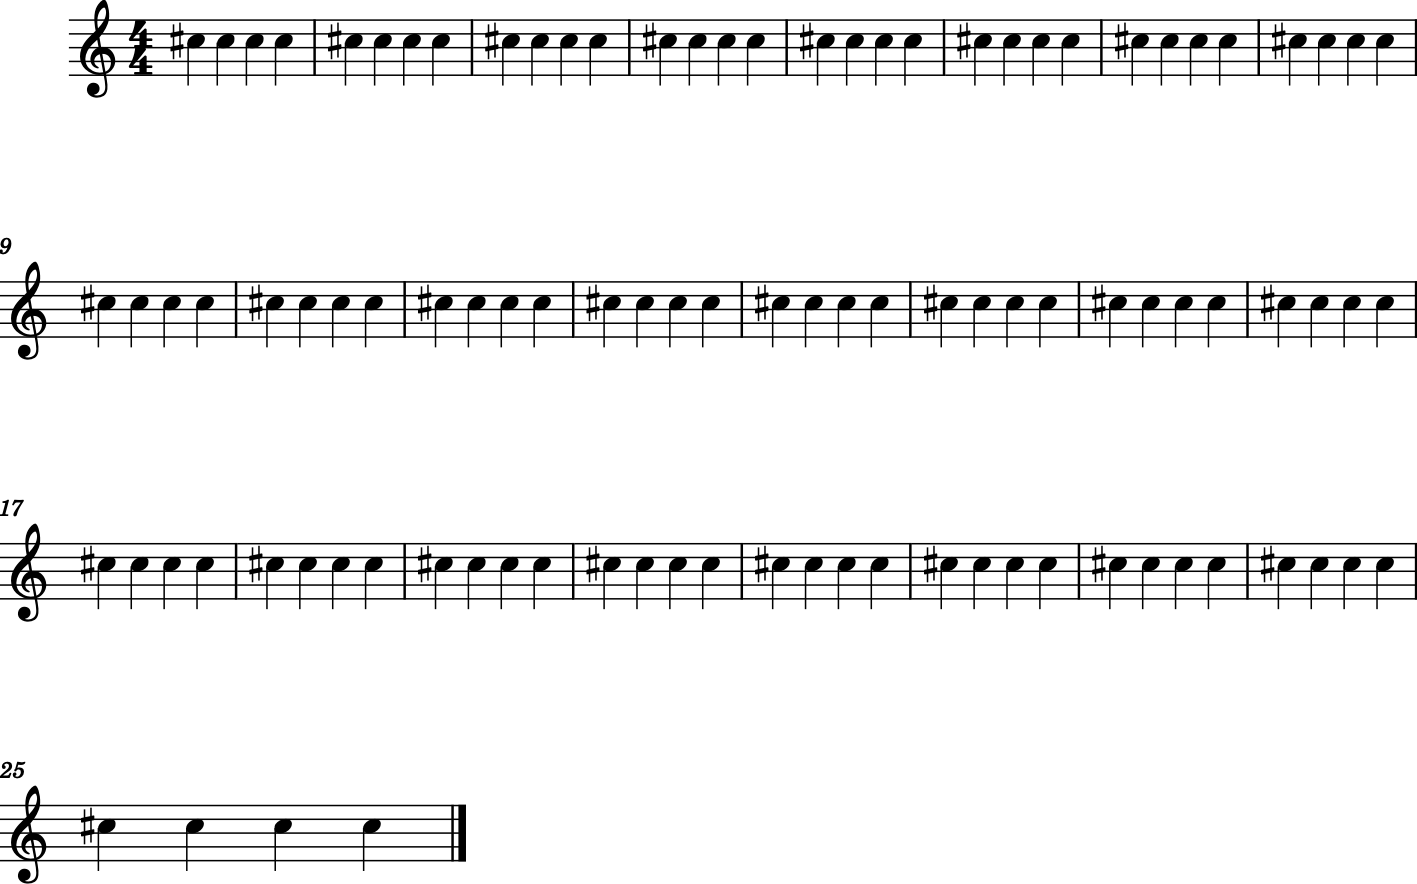

In [ ]:
def Malody_Generator(Note_Count, model, val_dataset, length, vocab_size, reverse_mapping, device='cpu'):
    # Choose a random seed from val_dataset
    seed_idx = np.random.randint(0, len(val_dataset) - 1)
    seed, _ = val_dataset[seed_idx]
    seed = seed.numpy()

    Music = ""
    Notes_Generated = []
    
    for i in range(Note_Count):
        seed_tensor = torch.tensor(seed, dtype=torch.float32).view(1, length, 1).to(device)
        
        model.eval()
        with torch.no_grad():
            prediction = model(seed_tensor)
        
        prediction = prediction.cpu().numpy()[0]
        prediction = np.log(prediction) / 1.0  # diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        
        index = np.argmax(prediction)
        index_N = index / float(vocab_size)
        
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        
        seed = np.insert(seed, len(seed), index_N)
        seed = seed[1:]
    
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)
    
    return Music, Melody_midi

# Generate and display the melody
Music_notes, Melody = Malody_Generator(
    Note_Count=100,
    model=model,
    val_dataset=val_dataset,
    length=40,  # Adjust based on your sequence length
    vocab_size=len(mapping),
    reverse_mapping=reverse_mapping,
    device='cpu'
)

Melody.show()


In [ ]:
Melody.write('midi','Melody_Generated.mid')
def beep():
    display(Audio('./Melody_Generated.mid', autoplay=True))
beep()

In [ ]:
sp = midi.realtime.StreamPlayer(Melody)
#sp.play()

AttributeError: 'Score' object has no attribute 'realtime'